<a href="https://colab.research.google.com/github/alexjercan/unsupervised-segmentation/blob/master/tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install matplotlib==3.3.3 albumentations==0.5.2

     |████████████████████████████████| 11.6MB 8.0MB/s 
     |████████████████████████████████| 81kB 12.0MB/s 
     |████████████████████████████████| 952kB 41.1MB/s 
     |████████████████████████████████| 38.2MB 67kB/s 
  Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [2]:

!git clone https://github.com/alexjercan/unsupervised-segmentation.git
%cd unsupervised-segmentation

import torch
from IPython.display import clear_output

clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Setup complete. Using torch 1.8.1+cu101 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15109MB, multi_processor_count=40)


In [3]:
# Download model
torch.hub.download_url_to_file('https://github.com/alexjercan/unsupervised-segmentation/releases/download/v1.0/normal.pth', 'normal.pth')

In [4]:
# Download dataset
torch.hub.download_url_to_file('https://github.com/alexjercan/unsupervised-segmentation/releases/download/v1.0/bdataset_scene.zip', 'tmp.zip')
!unzip -q tmp.zip -d ../ && rm tmp.zip

In [ ]:
!bash ./get_bdataset.sh

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   408    0   408    0     0   4434      0 --:--:-- --:--:-- --:--:--  4434
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 7494M    0 7494M    0     0  43.0M      0 --:--:--  0:02:54 --:--:-- 23.3M
Completed in 569 seconds


In [10]:
!git pull
!python dataset.py
start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)
start.record()
!python model.py
end.record()
torch.cuda.synchronize()
print(start.elapsed_time(end))

remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (1/1), done.
remote: Total 3 (delta 2), reused 3 (delta 2), pack-reused 0
Unpacking objects: 100% (3/3), done.
From https://github.com/alexjercan/unsupervised-segmentation
   6f0fe3d..15816d5  master     -> origin/master
Updating 6f0fe3d..15816d5
Fast-forward
 original.py | 13 +++++++++++++
 1 file changed, 13 insertions(+)
dataset ok
model ok
8623.9072265625


In [1]:
%cd unsupervised-segmentation/

/content/unsupervised-segmentation


In [2]:
import os
import re
import cv2
import torch
import torch.optim
import albumentations as A
import my_albumentations as M

from datetime import datetime as dt
from albumentations.pytorch.transforms import ToTensorV2
from config import DEVICE
from model import Model, LossFunction
from general import init_weights, load_checkpoint, save_checkpoint
from dataset import create_dataloader, create_dataloader_nyuv2, LoadImages
from metrics import MetricFunction, print_single_error, MetricFunctionNYUv2
from detect import generatePredictions
from train import train_one_epoch
from test import run_test, run_test_nyuv2
from util import save_predictions, plot_predictions

IMAGE_SIZE = 256
DATASET_ROOT = "../bdataset_scene"
TRAIN_JSON_PATH = "train.json"
TEST_JSON_PATH = "test.json"
IMAGES = [
          {"image": "data/0000.png", "depth": "data/0000.exr", "output": "data/out/0000.png"},
          {"image": "data/0001.png", "depth": "data/0001.exr", "output": "data/out/0001.png"},
          {"image": "data/0002.png", "depth": "data/0002.exr", "output": "data/out/0002.png"}
]
BATCH_SIZE = 8
WORKERS = 8

LEARNING_RATE = 1e-5
BETAS = [0.9, 0.999]
EPS = 1e-8
WEIGHT_DECAY = 1e-4

MILESTONES = [10]
GAMMA = 0.1

NUM_EPOCHS = 20
OUT_PATH ="./runs"
LOAD_TRAIN_MODEL = False
LOAD_TEST_MODEL = False
CHECKPOINT_TRAIN_FILE = "normal.pth"
CHECKPOINT_TEST_FILE = "normal.pth"

torch.backends.cudnn.benchmark = True

In [3]:
train_transform = A.Compose(
    [
        M.MyRandomResizedCrop(width=IMAGE_SIZE, height=IMAGE_SIZE),
        M.MyHorizontalFlip(p=0.5),
        M.MyVerticalFlip(p=0.1),
        A.OneOf([
            A.MotionBlur(p=0.2),
            A.MedianBlur(blur_limit=3, p=0.1),
            A.Blur(blur_limit=3, p=0.1),
        ], p=0.2),
        A.OneOf([
            M.MyOpticalDistortion(p=0.3),
            M.MyGridDistortion(p=0.1),
        ], p=0.2),
        A.OneOf([
            A.IAASharpen(),
            A.IAAEmboss(),
            A.RandomBrightnessContrast(),
        ], p=0.3),
        A.Normalize(),
        M.MyToTensorV2(),
    ],
    additional_targets={
        'normal': 'normal',
        'depth': 'depth',
    }
)

test_transform = A.Compose(
    [
        A.Normalize(),
        M.MyToTensorV2(),
    ],
    additional_targets={
        'normal': 'normal',
        'depth': 'depth',
    }
)

detect_transform = A.Compose(
    [
        M.MyLongestMaxSize(max_size=IMAGE_SIZE),
        M.MyPadIfNeeded(min_height=IMAGE_SIZE, min_width=IMAGE_SIZE, border_mode=cv2.BORDER_CONSTANT, value=0),
        A.Normalize(),
        M.MyToTensorV2(),
    ],
    additional_targets={
        'depth' : 'depth',
    }
)

_, train_dataloader = create_dataloader(DATASET_ROOT, TRAIN_JSON_PATH, 
                                        batch_size=BATCH_SIZE, transform=train_transform, 
                                        workers=WORKERS, pin_memory=True, shuffle=True)

_, test_dataloader = create_dataloader(DATASET_ROOT, TEST_JSON_PATH,
                                       batch_size=BATCH_SIZE, transform=test_transform,
                                       workers=WORKERS, pin_memory=True, shuffle=False)

In [7]:
model = Model(num_classes=10, num_layers=3)
model.apply(init_weights)
solver = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), 
                          lr=LEARNING_RATE, betas=BETAS, 
                          eps=EPS, weight_decay=WEIGHT_DECAY)
lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(solver, milestones=MILESTONES, gamma=GAMMA)
model = model.to(DEVICE)
loss_fn = LossFunction()

In [5]:
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

print(get_n_params(model))

75530090


In [ ]:
epoch_idx = 0
if LOAD_TRAIN_MODEL:
    epoch_idx, model = load_checkpoint(model, CHECKPOINT_TRAIN_FILE, DEVICE)

model.train()
for epoch_idx in range(epoch_idx, NUM_EPOCHS):
    metric_fn = MetricFunction(BATCH_SIZE)
    train_one_epoch(model, train_dataloader, loss_fn, metric_fn, solver, epoch_idx)
    print_single_error(epoch_idx, loss_fn.show(), metric_fn.show())
    lr_scheduler.step()

In [ ]:
if LOAD_TEST_MODEL:
    epoch_idx, model = load_checkpoint(model, CHECKPOINT_TEST_FILE, DEVICE)

model.eval()
metric_fn = MetricFunction(BATCH_SIZE)
run_test(model, test_dataloader, loss_fn, metric_fn)
print_single_error(epoch_idx, loss_fn.show(), metric_fn.show())

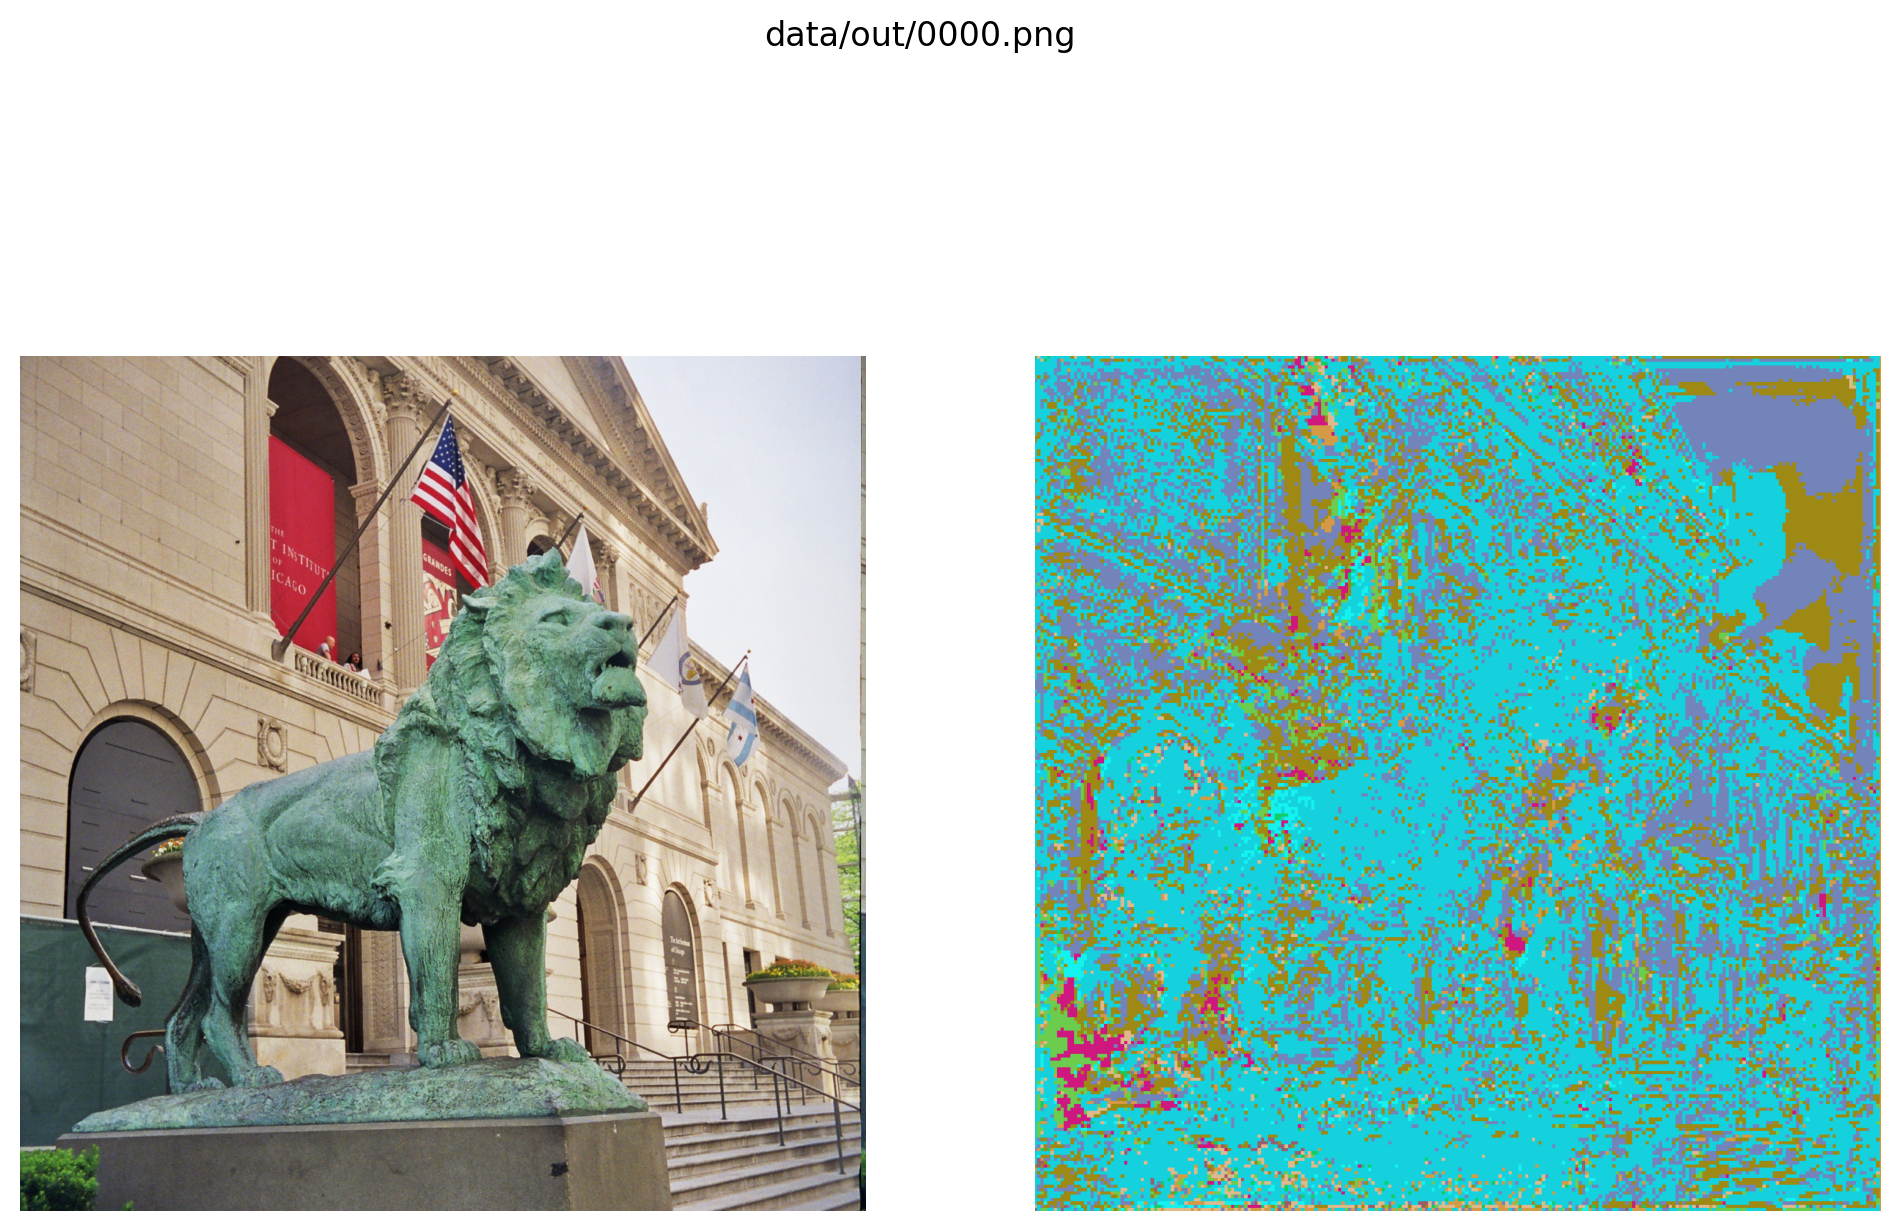

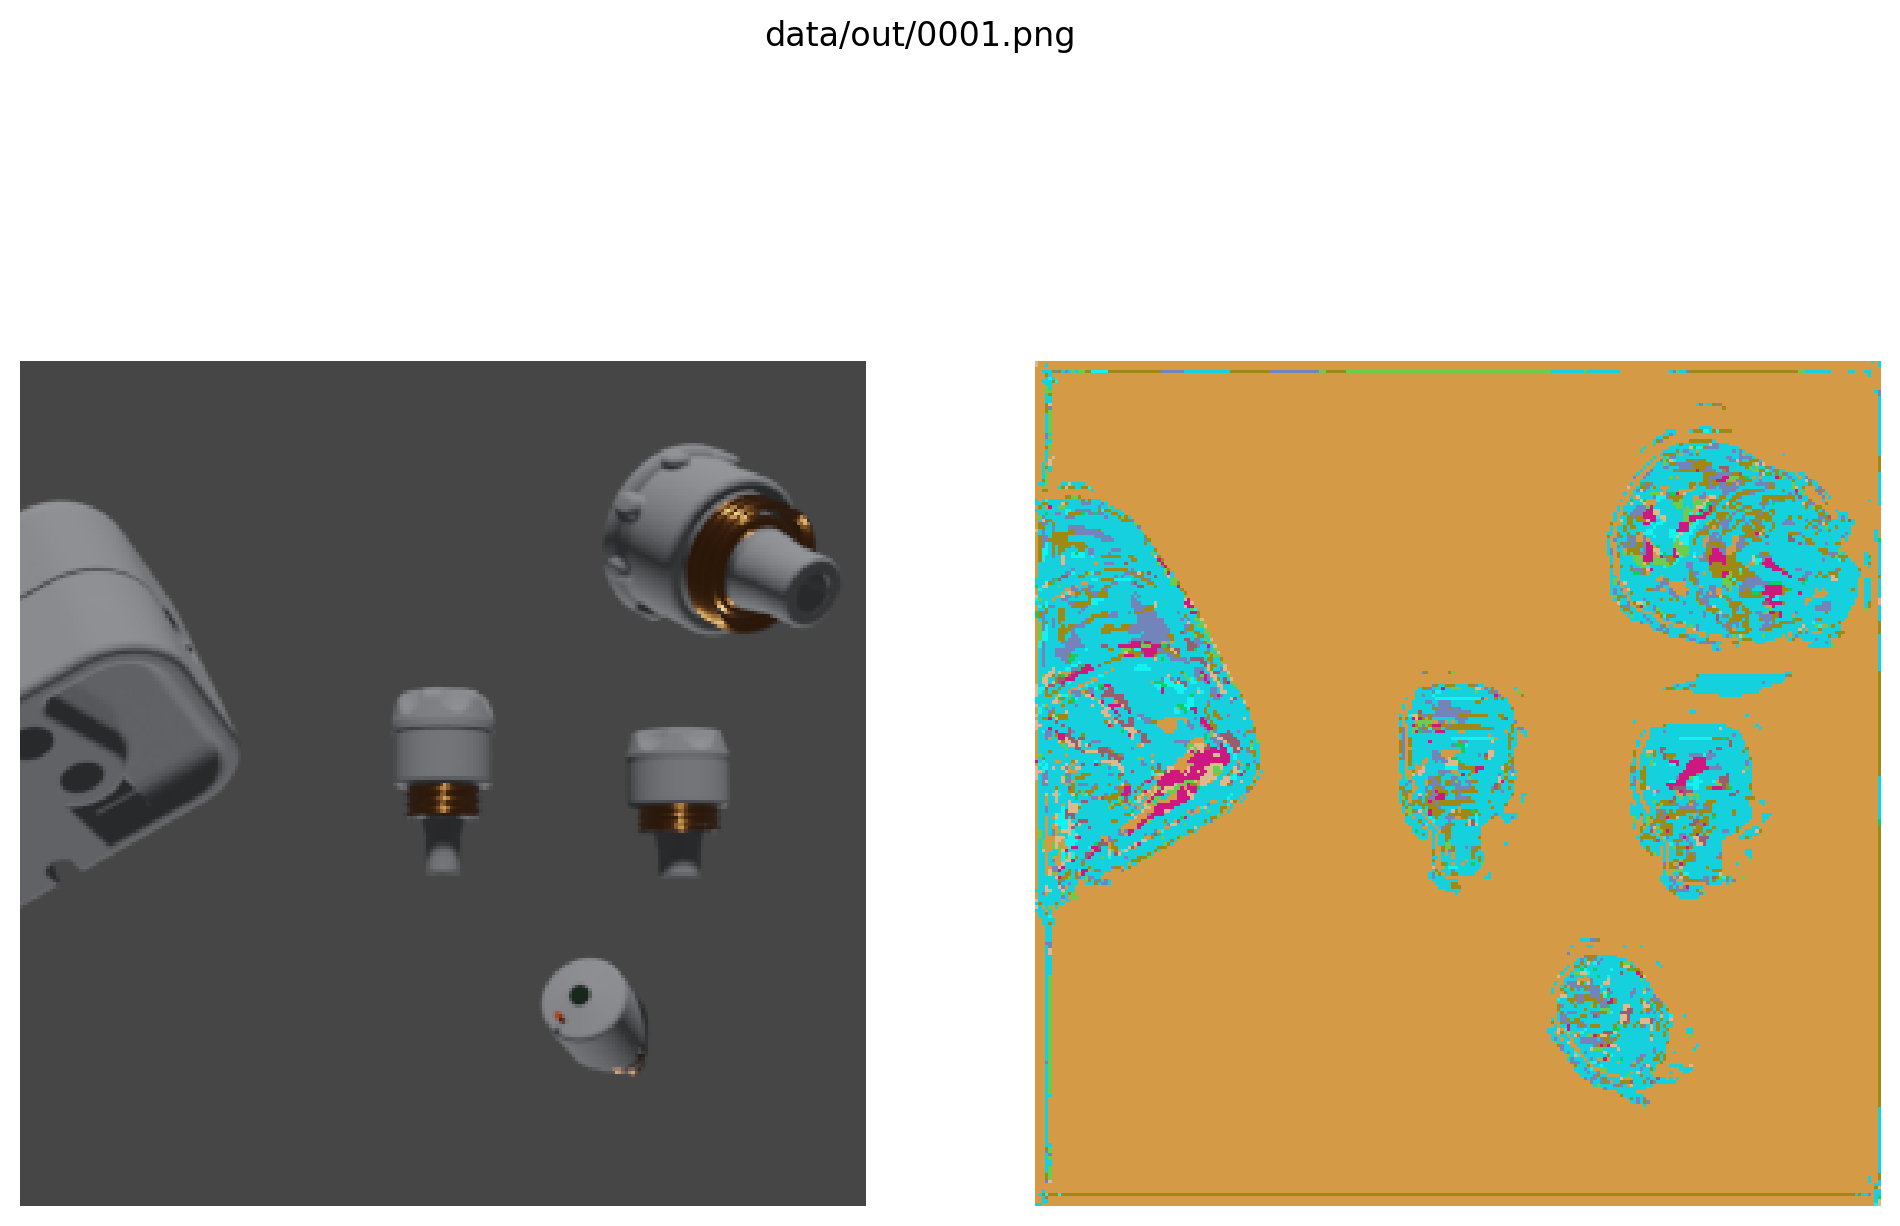

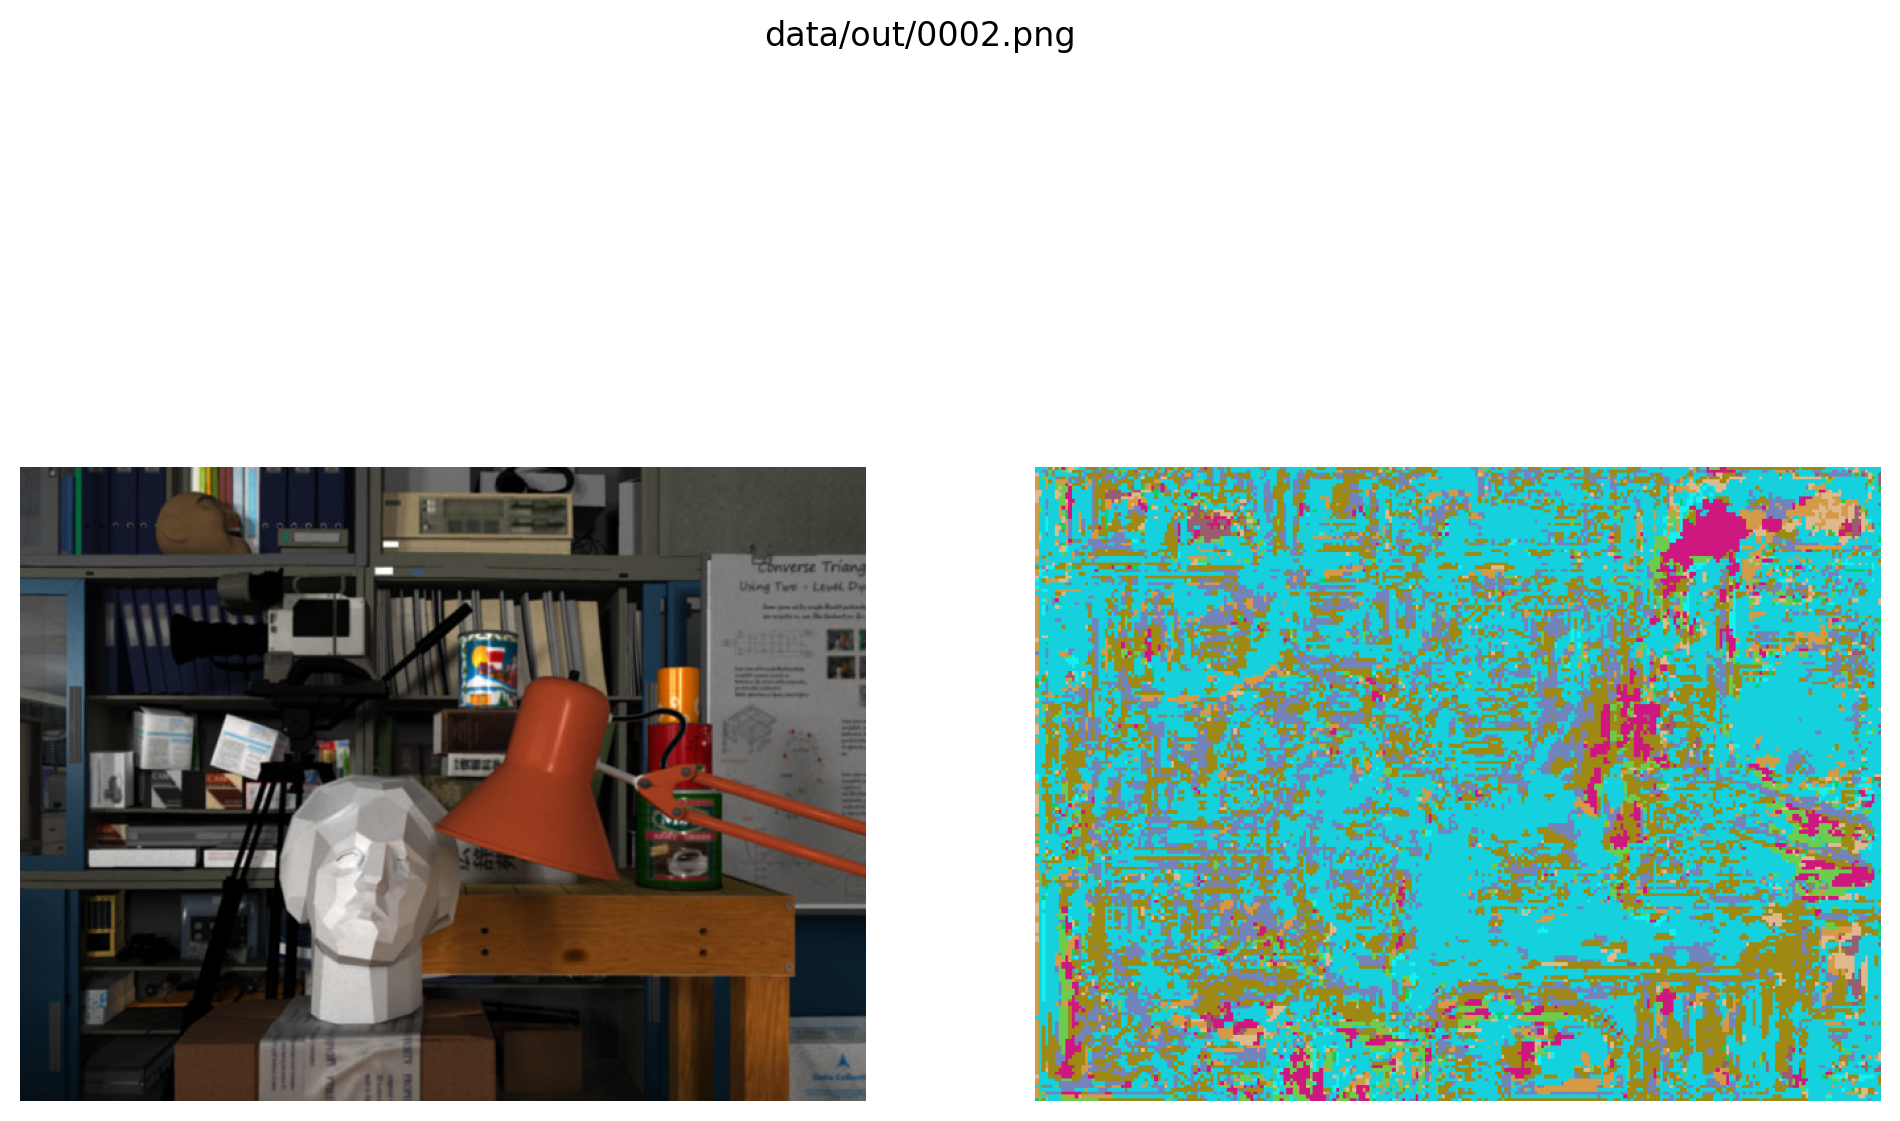

In [6]:
# if LOAD_TEST_MODEL:
epoch_idx, model = load_checkpoint(model, CHECKPOINT_TEST_FILE, DEVICE)

model.eval()
images = LoadImages(IMAGES, transform=detect_transform)
for img, predictions, depths, path in generatePredictions(model, images):
    plot_predictions([img], predictions, depths, [path])
    save_predictions([img], predictions, depths, [path])

In [19]:
output_dir = os.path.join(OUT_PATH, re.sub("[^0-9a-zA-Z]+", "-", dt.now().isoformat()))

save_checkpoint(epoch_idx, model, output_dir)

NYU v2 Dataset

In [4]:
_, test_dataloader_nyuv2 = create_dataloader_nyuv2(batch_size=BATCH_SIZE, transform=test_transform, workers=WORKERS, pin_memory=True, shuffle=False)

In [8]:
if LOAD_TEST_MODEL:
    epoch_idx, model = load_checkpoint(model, CHECKPOINT_TEST_FILE, DEVICE)

model.eval()
metric_fn = MetricFunctionNYUv2(BATCH_SIZE)
run_test_nyuv2(model, test_dataloader_nyuv2, loss_fn, metric_fn)
print_single_error(epoch_idx, loss_fn.show(), metric_fn.show())

  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:128: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  img = torch.from_numpy(np.array(pic, np.int32, copy=False))
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:128: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable befo

eval_avg_error
Epoch: 20, loss=(total:3.4694 c:0.8977 s:2.5717)
======SEGMENTATION========
IOU=0.0397	P=0.1985	R=0.0016	F1=0.0031




OG Model kanezaki github

In [5]:
from original import OgModel, OgLossFunction, og_train_one_epoch, og_run_test, og_run_test_nyuv2

In [13]:
start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)
start.record()
!python original.py
end.record()
torch.cuda.synchronize()
print(start.elapsed_time(end))

model ok
5622.5693359375


In [9]:
model = OgModel(num_classes=10)
model.apply(init_weights)
solver = torch.optim.SGD(filter(lambda p: p.requires_grad, model.parameters()),
                         lr=LEARNING_RATE, momentum=0.9,
                         dampening=0.1, weight_decay=WEIGHT_DECAY)
lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(solver, milestones=MILESTONES, gamma=GAMMA)
model = model.to(DEVICE)
loss_fn = OgLossFunction()

In [ ]:
epoch_idx = 0
if LOAD_TRAIN_MODEL:
    epoch_idx, model = load_checkpoint(model, CHECKPOINT_TRAIN_FILE, DEVICE)

model.train()
for epoch_idx in range(epoch_idx, NUM_EPOCHS):
    metric_fn = MetricFunction(BATCH_SIZE)
    og_train_one_epoch(model, train_dataloader, loss_fn, metric_fn, solver, epoch_idx)
    print_single_error(epoch_idx, loss_fn.show(), metric_fn.show())
    lr_scheduler.step()

In [ ]:
if LOAD_TEST_MODEL:
    epoch_idx, model = load_checkpoint(model, CHECKPOINT_TEST_FILE, DEVICE)

model.eval()
metric_fn = MetricFunction(BATCH_SIZE)
og_run_test(model, test_dataloader, loss_fn, metric_fn)
print_single_error(epoch_idx, loss_fn.show(), metric_fn.show())

In [10]:
if LOAD_TEST_MODEL:
    epoch_idx, model = load_checkpoint(model, CHECKPOINT_TEST_FILE, DEVICE)

model.eval()
metric_fn = MetricFunctionNYUv2(BATCH_SIZE)
og_run_test_nyuv2(model, test_dataloader_nyuv2, loss_fn, metric_fn)
print_single_error(epoch_idx, loss_fn.show(), metric_fn.show())

  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:128: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  img = torch.from_numpy(np.array(pic, np.int32, copy=False))
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:128: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable befo

eval_avg_error
Epoch: 20, loss=(total:2.9240 s:1.0791 c:1.8449)
======SEGMENTATION========
IOU=0.0396	P=0.1761	R=0.0014	F1=0.0027


